### Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from pathlib import Path
import torch
from tqdm import tqdm_notebook
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai import vision
from fastai.vision import ClassificationInterpretation
from fastai.vision.learner import *
from fastai.vision.models import *
from fastai.vision.data import *
from fastai.metrics import error_rate, accuracy
torch.cuda.set_device(0)

In [3]:
torch.backends.cudnn.benchmark=True

In [4]:
df = pd.read_csv('pklot_formatted_data.csv')
df.head()

,contour,date_id,parking_id,image_path,json_path,occupied,rotated_rect_center_x,rotated_rect_center_y,rotated_rect_degree,rotated_rect_height,rotated_rect_width
0,"[{'x': '641', 'y': '570'}, {'x': '726', 'y': '...",2013-01-18_18_35_15,1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,json/2013-01-18_18_35_15.json,0,651,636,-34,141,83
1,"[{'x': '698', 'y': '505'}, {'x': '782', 'y': '...",2013-01-18_18_35_15,2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,json/2013-01-18_18_35_15.json,1,705,563,-44,139,77
2,"[{'x': '719', 'y': '427'}, {'x': '799', 'y': '...",2013-01-18_18_35_15,3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,json/2013-01-18_18_35_15.json,1,732,480,-48,124,60
3,"[{'x': '754', 'y': '367'}, {'x': '824', 'y': '...",2013-01-18_18_35_15,4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,json/2013-01-18_18_35_15.json,0,762,409,-51,113,54
4,"[{'x': '767', 'y': '313'}, {'x': '833', 'y': '...",2013-01-18_18_35_15,5,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,json/2013-01-18_18_35_15.json,0,773,346,-56,109,49


In [5]:
empty = list(Path().glob('PKLot/PKLotSegmented/*/*/*/Empty/*.jpg'))
segmented = pd.DataFrame({'fn': empty, 'cat': 'empty'}, columns=['fn', 'cat'])
occupied = list(Path().glob('PKLot/PKLotSegmented/*/*/*/Occupied/*.jpg'))
segmented = pd.concat([segmented, pd.DataFrame({'fn': occupied, 'cat': 'occupied'})])

In [6]:
segmented.head()

,fn,cat
0,PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/E...,empty
1,PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/E...,empty
2,PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/E...,empty
3,PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/E...,empty
4,PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/E...,empty


### Helper Functions

### DE CODE

In [7]:
f_model = resnet34
sz=50
bs=512
tfms = vision.transform.get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=4., 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0., 
                      p_affine=0.75, 
                      p_lighting=0.75)
padding_mode='zeros'
data = (ImageItemList.from_df(path='.', df=segmented, cols='fn')
                     .random_split_by_pct(valid_pct=0.2, seed=10)
                     .label_from_df(cols='cat')
                     .transform(tfms, size=sz, padding_mode=padding_mode)
                     .databunch(bs=bs, num_workers=4)
                     .normalize(imagenet_stats))

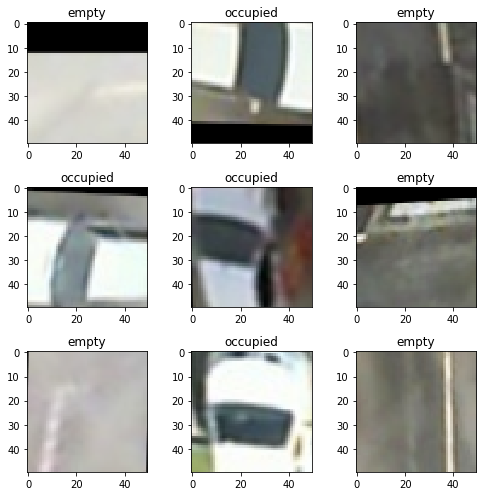

In [8]:
data.show_batch(rows=3, figsize=(7,7), hide_axis=False)

In [9]:
learn = create_cnn(data, f_model, metrics=[error_rate, accuracy])

In [10]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.027428,0.012643,0.003406,0.996594
2,0.013435,0.006406,0.001495,0.998505
3,0.010694,0.004738,0.000984,0.999016
4,0.009605,0.004457,0.000934,0.999066
5,0.008063,0.004077,0.000783,0.999217
6,0.010210,0.004117,0.000798,0.999202


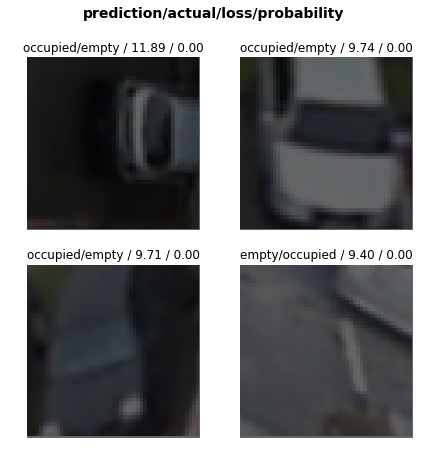

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(7,7))

In [12]:
lrf=learn.lr_find(1e-5,100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.01E-05


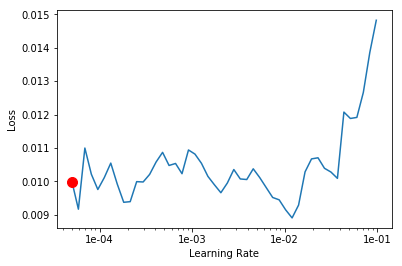

In [13]:
learn.recorder.plot()

In [14]:
learn.save('segmented_classifer')

NameError: name 'md' is not defined

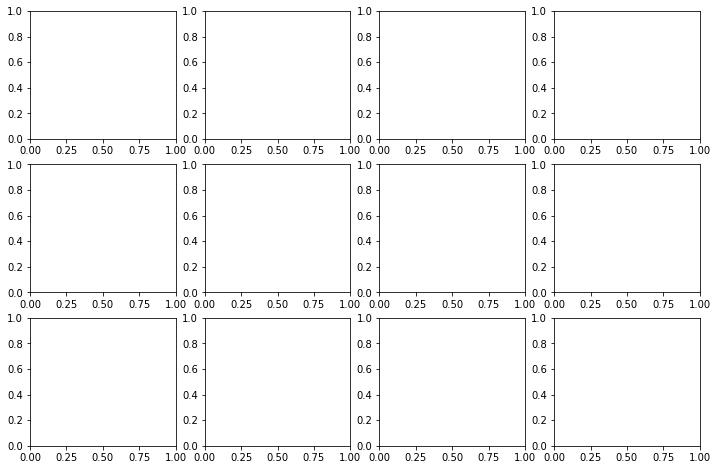

In [15]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()